# Inspecting Correlations and Predicting Factors for Sales Amounts

In [ ]:
#import dependencies
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
%matplotlib inline

In [28]:
df=pd.read_excel('data.xlsx')
df.to_csv('df_output.csv', encoding='utf-8')
df=pd.read_csv('df_output.csv')
df=df.iloc[:,1:]
print df.shape
print df.dtypes
df.head()

(756, 15)
Account ID            object
Region                object
Opportunity ID        object
Account Type          object
Product Type          object
Type                  object
Amount               float64
ARR                    int64
# of Months          float64
Created Date          object
Close Date            object
Age                    int64
Stage                 object
Fiscal Period         object
Opportunity Owner     object
dtype: object


,Account ID,Region,Opportunity ID,Account Type,Product Type,Type,Amount,ARR,# of Months,Created Date,Close Date,Age,Stage,Fiscal Period,Opportunity Owner
0,EA Electronic Arts,NaN,006w000000ldPZu,Customer,JFrog Pro Plus,New Business,121500.0,40500,12.0,2016-08-26,2016-10-12,46,06-Closed Won,Q4-2016,Star Fox
1,Jama Software,NaN,006w000000k8oEa,Customer,JFrog Pro,New Business,8250.0,8250,12.0,2016-06-06,2016-06-08,2,06-Closed Won,Q2-2016,Star Fox
2,Vidder,NaN,006w000000k8oTV,Customer,JFrog Pro Plus,New Business,36000.0,36000,12.0,2016-06-06,2016-06-23,17,06-Closed Won,Q2-2016,Star Fox
3,NaN,NaN,006w000000oCdAD,Prospect,JFrog Pro,New Business,8850.0,8850,12.0,2016-12-21,2017-01-09,19,06-Closed Lost,Q1-2017,Star Fox
4,Expedia- Hotel.com,NaN,006w000000kP366,Customer,JFrog Enterprise,New Business,205500.0,205500,12.0,2016-08-05,2017-03-08,215,06-Closed Lost,Q1-2017,Star Fox


In [29]:
for i in list(df):
    print i
    print df[i].nunique()

Account ID
575
Region
3
Opportunity ID
756
Account Type
4
Product Type
9
Type
1
Amount
158
ARR
163
# of Months
3
Created Date
377
Close Date
319
Age
223
Stage
7
Fiscal Period
7
Opportunity Owner
3


In [30]:
df.isnull().sum()

Account ID            47
Region               682
Opportunity ID         0
Account Type           0
Product Type           0
Type                   0
Amount                 0
ARR                    0
# of Months           15
Created Date           0
Close Date             0
Age                    0
Stage                  0
Fiscal Period          0
Opportunity Owner      0
dtype: int64

In [31]:
df['lost']=df['Stage'].apply(lambda x: 1 if 'Closed Lost' in x else 0)
df.loc[df.lost==1,'Amount']=0
df.loc[df.lost==1,'ARR']=0
df=df.drop(columns=['lost'])
df.to_csv('df_tableau.csv', encoding='utf-8')
df.head()

,Account ID,Region,Opportunity ID,Account Type,Product Type,Type,Amount,ARR,# of Months,Created Date,Close Date,Age,Stage,Fiscal Period,Opportunity Owner
0,EA Electronic Arts,NaN,006w000000ldPZu,Customer,JFrog Pro Plus,New Business,121500.0,40500,12.0,2016-08-26,2016-10-12,46,06-Closed Won,Q4-2016,Star Fox
1,Jama Software,NaN,006w000000k8oEa,Customer,JFrog Pro,New Business,8250.0,8250,12.0,2016-06-06,2016-06-08,2,06-Closed Won,Q2-2016,Star Fox
2,Vidder,NaN,006w000000k8oTV,Customer,JFrog Pro Plus,New Business,36000.0,36000,12.0,2016-06-06,2016-06-23,17,06-Closed Won,Q2-2016,Star Fox
3,NaN,NaN,006w000000oCdAD,Prospect,JFrog Pro,New Business,0.0,0,12.0,2016-12-21,2017-01-09,19,06-Closed Lost,Q1-2017,Star Fox
4,Expedia- Hotel.com,NaN,006w000000kP366,Customer,JFrog Enterprise,New Business,0.0,0,12.0,2016-08-05,2017-03-08,215,06-Closed Lost,Q1-2017,Star Fox


In [32]:
#convert datetime to unix
df['Created Date']=pd.to_datetime(df['Created Date'])
df['Created Date']=df['Created Date'].apply(lambda x: x.timestamp())
df['Close Date']=pd.to_datetime(df['Close Date'])
df['Close Date']=df['Close Date'].apply(lambda x: x.timestamp())

In [7]:
df=df.drop(columns=['Opportunity ID','Region'])
cat_columns=list(df.select_dtypes(include=['object']))
cat_dummy_df=pd.get_dummies(df[cat_columns].applymap(str).applymap(str))
cat_dummy_df.head()

,Account ID_20th Century Fox,Account ID_ABC Financial,Account ID_ADP,"Account ID_ADTRAN, Inc.",Account ID_AIM Specialty Health,Account ID_ALSAC/St. Jude Children\'s Research Hospital,Account ID_ANZ,Account ID_APS,Account ID_ASRC Federal,Account ID_AT&T,...,Fiscal Period_Q1-2017,Fiscal Period_Q2-2016,Fiscal Period_Q2-2017,Fiscal Period_Q3-2016,Fiscal Period_Q3-2017,Fiscal Period_Q4-2016,Fiscal Period_Q4-2017,Opportunity Owner_Baconator,Opportunity Owner_Charmander,Opportunity Owner_Star Fox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [8]:
corr_df=pd.concat([df[[x for x in list(df) if x not in cat_columns]],cat_dummy_df],axis=1)
corr_df.head()

,Amount,ARR,# of Months,Created Date,Close Date,Age,Account ID_20th Century Fox,Account ID_ABC Financial,Account ID_ADP,"Account ID_ADTRAN, Inc.",...,Fiscal Period_Q1-2017,Fiscal Period_Q2-2016,Fiscal Period_Q2-2017,Fiscal Period_Q3-2016,Fiscal Period_Q3-2017,Fiscal Period_Q4-2016,Fiscal Period_Q4-2017,Opportunity Owner_Baconator,Opportunity Owner_Charmander,Opportunity Owner_Star Fox
0,121500.0,40500,12.0,1.472170e+09,1.476230e+09,46,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,8250.0,8250,12.0,1.465171e+09,1.465344e+09,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,36000.0,36000,12.0,1.465171e+09,1.466640e+09,17,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.0,0,12.0,1.482278e+09,1.483920e+09,19,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0.0,0,12.0,1.470355e+09,1.488931e+09,215,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [9]:
corr = corr_df.corrwith(corr_df['Amount'])
corr.sort_values(ascending=False).head(20)

Amount                                    1.000000
ARR                                       0.893800
# of Months                               0.502832
Product Type_JFrog Enterprise             0.419176
Account ID_Salesforce                     0.259860
Account ID_BANK OF AMERICA                0.230337
Account ID_Wells Fargo                    0.204670
Account ID_Morgan Stanley                 0.174302
Age                                       0.170252
Account ID_PNC                            0.165236
Stage_06-Closed Won                       0.161068
Account ID_Intuit, Inc.                   0.154715
Account Type_Customer                     0.130313
Account ID_TD Ameritrade                  0.120942
Account ID_MRI Software LLC               0.120258
Account ID_State Street                   0.115077
Account ID_The Bank of New York Mellon    0.089834
Account ID_Duke Energy                    0.078407
Account ID_CVS Health                     0.078407
Account ID_IRESS Ltd.          

In [10]:
corr.sort_values(ascending=True).head(20)

Product Type_JFrog Pro                      -0.270311
Stage_06-Closed Lost                        -0.176042
Account Type_Prospect                       -0.121791
Opportunity Owner_Charmander                -0.103832
Account ID_nan                              -0.074725
Product Type_JFrog Pro Plus                 -0.067108
Created Date                                -0.064496
Product Type_Artifactory SaaS Enterprise    -0.054203
Product Type_Artifactory SaaS Pro Prepaid   -0.052255
Fiscal Period_Q1-2017                       -0.043318
Fiscal Period_Q3-2017                       -0.042080
Account Type_Former                         -0.035637
Account ID_Cisco                            -0.021214
Account ID_McKesson                         -0.020893
Account ID_The MITRE Corporation            -0.019934
Account ID_Accenture                        -0.019721
Stage_04-Solution                           -0.019375
Account ID_Palo Alto Networks               -0.018549
Account ID_US Navy          

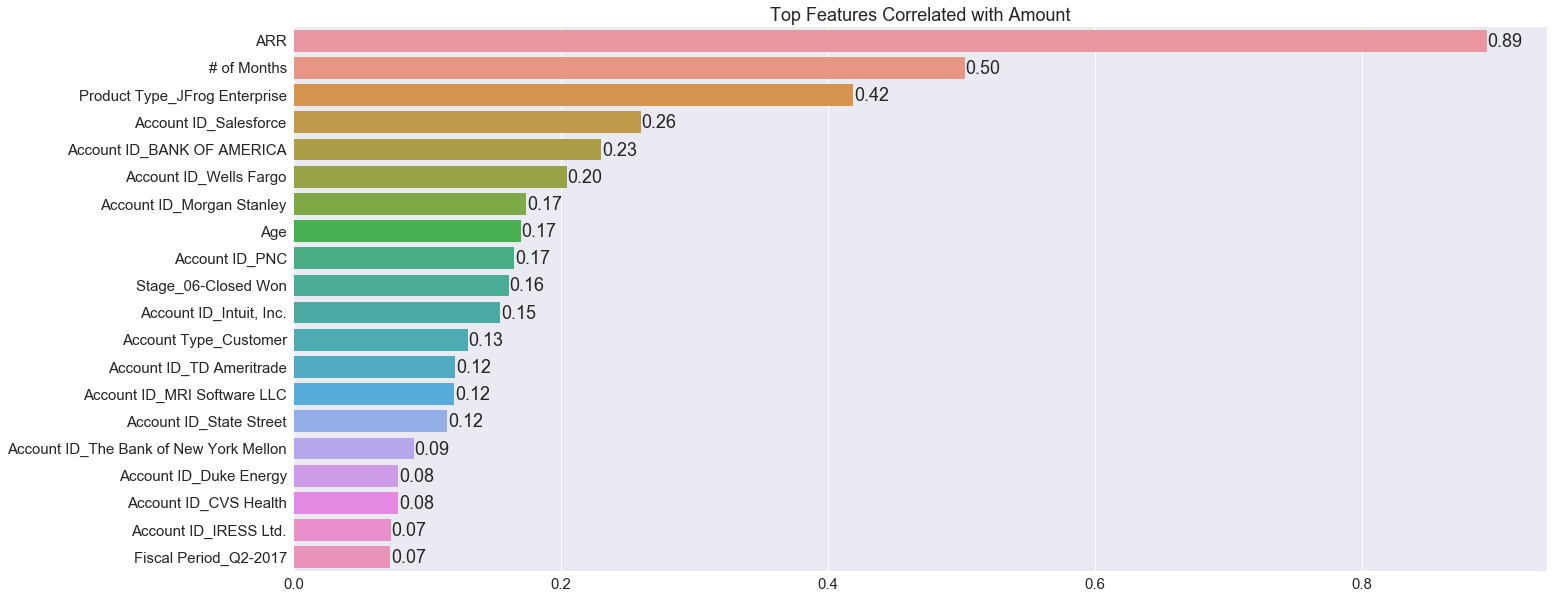

In [11]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,10))
plt.title("Top Features Correlated with Amount")
ax=sns.barplot(y=corr.sort_values(ascending=False)[1:].head(20).index,\
            x=corr.sort_values(ascending=False)[1:].head(20),orient='h')

for p in ax.patches:
    width = p.get_width()
    plt.text(0.0005+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='left', va='center') 

plt.show()

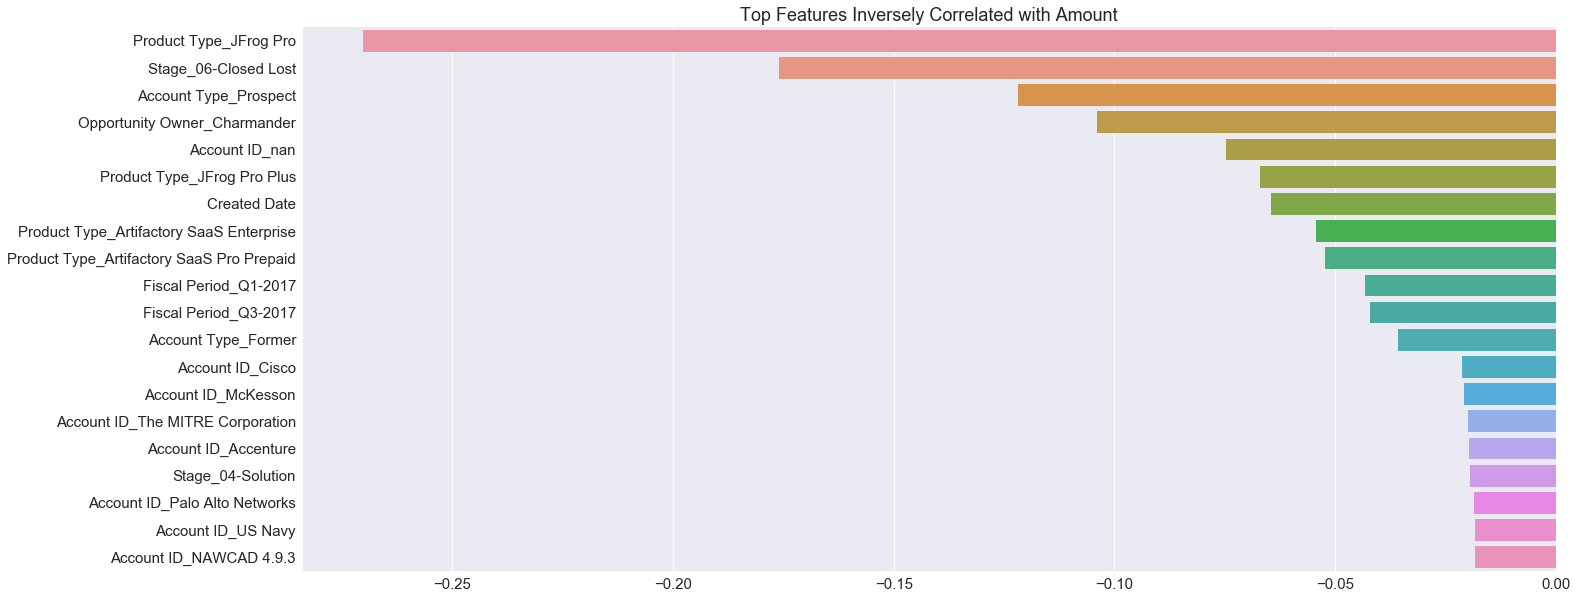

In [12]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20,10))
plt.title("Top Features Inversely Correlated with Amount")
ax=sns.barplot(y=corr.sort_values(ascending=True).head(20).index,\
            x=corr.sort_values(ascending=True).head(20),orient='h')


plt.show()

In [13]:
Y=corr_df['Amount']
X=corr_df.drop(columns=['Amount','ARR'])

In [14]:
# using a regressor based and calculate rmse
#Validation function
n_folds = 3

#function to evaluate each model
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)#.get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = kf, verbose=True))
    return(rmse)

In [15]:
clf = xg.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:linear',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
clf.set_params(nthread = -1)
clf.set_params(silent = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=False, subsample=0.8)

In [16]:
print 'root mean squared error'
print rmsle_cv(clf)


root mean squared error
[158738.59903149  54270.98368972  84917.64732627]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.6s finished


/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Distribution of Amount
count    7.560000e+02
mean     5.198044e+04
std      1.482229e+05
min      0.000000e+00
25%      8.250000e+03
50%      8.850000e+03
75%      4.320000e+04
max      2.844186e+06
Name: Amount, dtype: float64


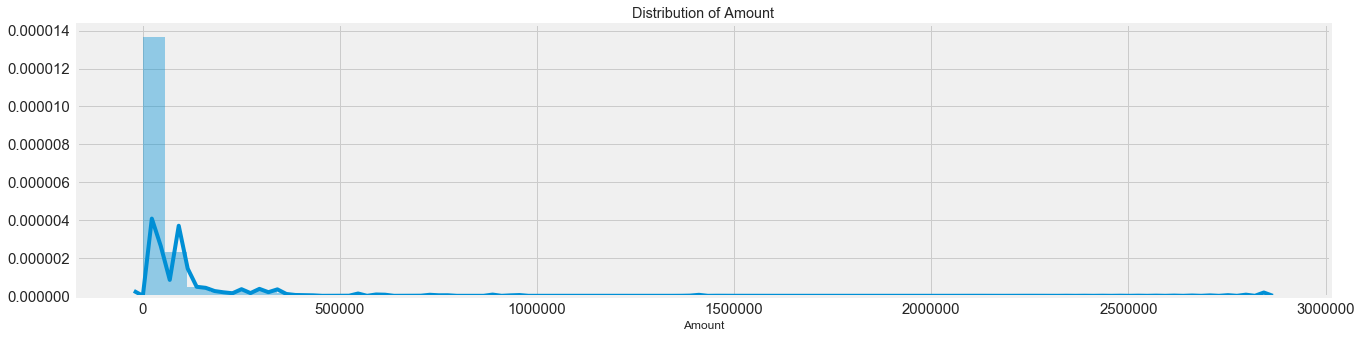

In [33]:
plt.figure(figsize=(20,5))
plt.title('Distribution of Amount')
sns.distplot(Y)
print 'Distribution of Amount'
print Y.describe()

In [18]:
clf.fit(X,Y, eval_metric='rmse', verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=False, subsample=0.8)

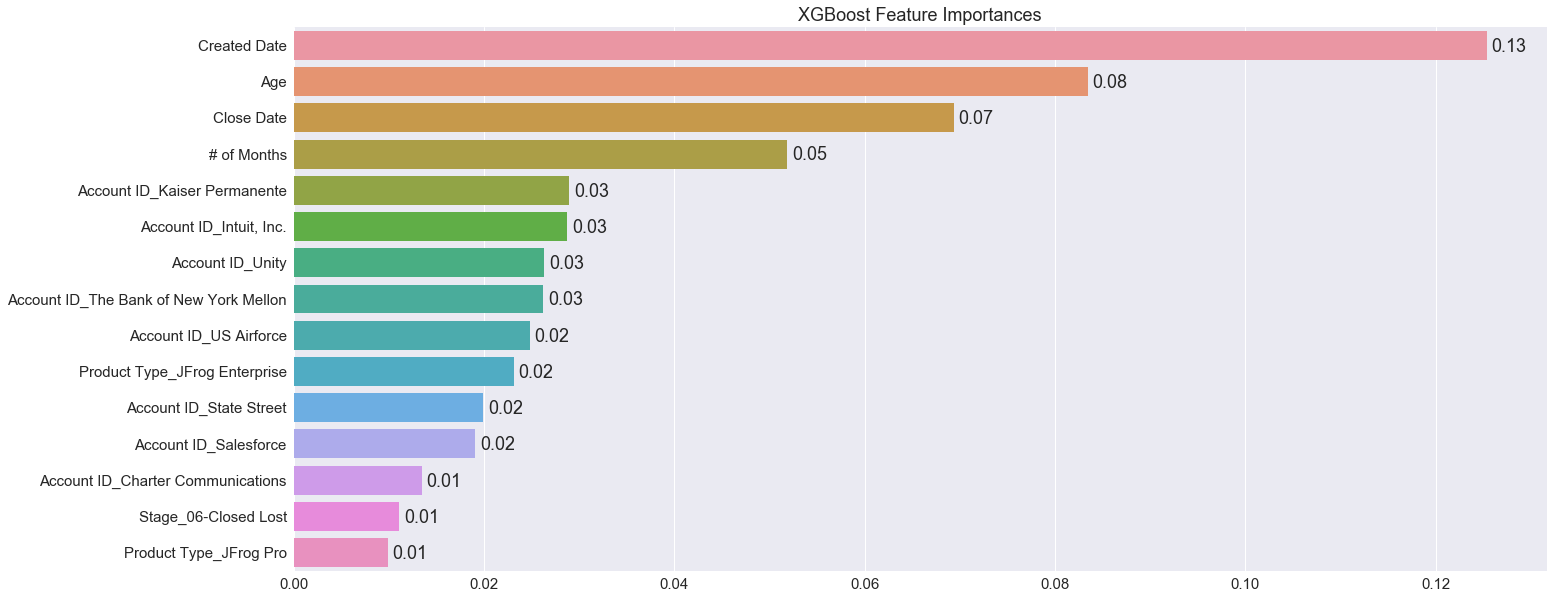

In [19]:
top_15_feat_importance=pd.Series(clf.feature_importances_,X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(20,10))
plt.title('XGBoost Feature Importances')
ax=sns.barplot(y=top_15_feat_importance.index,x=top_15_feat_importance,orient='h')
for p in ax.patches:
    width = p.get_width()
    plt.text(0.0005+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='left', va='center') 
plt.show()

# What Could Improve Model Performance
- Generating Synthetic Samples with Noise (Upsampling)
- Imputing Missing Values
- Preprocessing Steps (Log Transforming Numeric Values, Standard Scaling)
- More Data
